In [ ]:
!pip3 install imageio[ffmpeg]
!pip3 install imageio[pyav]

In [1]:
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
from deep_sort import generate_detections as gdet

2024-11-26 18:57:22.192412: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 18:57:22.350215: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 18:57:23.102104: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/targets/x86_64-linux/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-11-26 18:57:23.102395: W tensorflow/stream_executor/platf

In [2]:
from flask import Flask, request, jsonify, make_response
from flask_cors import CORS
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
import base64, ssl, json
import matplotlib.pyplot as plt
from ultralytics import YOLO
import imageio.v3 as iio

In [3]:
det_model = YOLO("yolov8n.pt")

def detect_person(img, conf_threshold=0.5, ret_coord=False):
    result=det_model.cpu()(img, verbose=False)
    boxes=np.array([np.array([box.xyxyn[0][1],box.xyxyn[0][0],box.xyxyn[0][3],box.xyxyn[0][2]]) for box in result[0].boxes if box.cls==0 and box.conf>=conf_threshold])

    _img=tf.repeat(img[None], len(boxes), axis=0)

    cropped_image=tf.image.crop_and_resize(_img, boxes, range(len(boxes)), (128,64))
    
    if ret_coord:
        return tf.image.crop_and_resize(_img, boxes, range(len(boxes)), (128,64)), boxes
    else:
        return tf.image.crop_and_resize(_img, boxes, range(len(boxes)), (128,64))

In [357]:
sim_model=load_model('Models/DenseNet121.h5', compile=False)

In [4]:
sim_model=load_model('Models/EfficientNetB2.h5', compile=False)

2024-11-26 17:08:55.941813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 17:08:56.213563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79038 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 7g.80gb, pci bus id: 0000:01:00.0, compute capability: 8.0


In [8]:
from pathlib import Path

_bytes = Path("test.mp4").read_bytes()

In [9]:
frames=iio.imread(_bytes, index=None)

In [11]:
img=iio.imread('test.png')[...,:3]

In [12]:
target=detect_person(img)[0]

In [1245]:
i=50
cnt=50
_cnt=0

weighted_image = target

In [1246]:
ewa_coord=None

In [1247]:
exp4coord = lambda x:tf.math.exp(-x**2/0.05).numpy()
exp4sim = lambda x:tf.math.exp(-(1.-x)**2/0.08).numpy()
exp4cnt = lambda x:tf.math.exp(-x**2/5000.).numpy()
act4alpha = lambda x:tf.math.tanh(x/100.).numpy()

In [1248]:
target_image_alpha=0.2

tf.Tensor(0.69278824, shape=(), dtype=float32) [     0.5372     0.69279     0.50483     0.58328     0.46232     0.29764     0.18305     0.55072     0.53022]
tf.Tensor(0.30735916, shape=(), dtype=float32)
55.0
0.5005202111902352
[      1.333     0.02982     0.11291    0.069734    0.049019     0.12103     0.13044    0.043191]


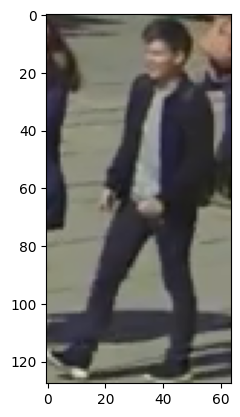

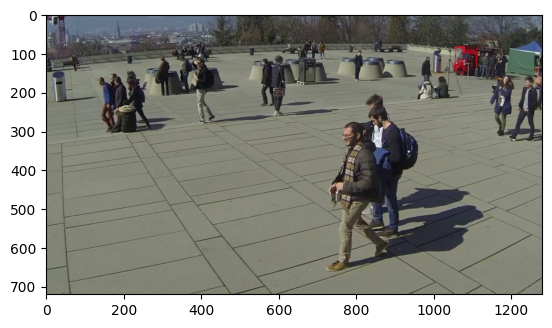

In [1255]:
sources,coords = detect_person(frames[i],ret_coord=True)
targets = tf.repeat((weighted_image)[None],len(sources), axis=0)
data = tf.concat([targets,sources], axis=-1)
ret = sim_model.predict(data, batch_size=32, verbose=0)[:,0]

if ewa_coord is None:
    idx = tf.argmax(ret)
    ewa_coord = coords[idx]
else:
    se = (ewa_coord-coords)**2
    dist_coord1 = tf.reduce_sum(se[:,:2], axis=-1)**0.5
    dist_coord2 = tf.reduce_sum(se[:,2:], axis=-1)**0.5

    score_sim = exp4sim(ret)
    score_coord1 = exp4coord(dist_coord1)
    score_coord2 = exp4coord(dist_coord2)

    if tf.reduce_max(score_sim)>=0.5:
        score = (1-act4alpha(cnt))*score_sim + act4alpha(cnt)*(score_coord1+score_coord2)

        if tf.reduce_max(score)>=0.7:
            cnt+=1
            _cnt = cnt
            ncnt=0
            
            print("Detected")
            idx=tf.argmax(score)

            ewa_coord = act4alpha(cnt)*coords[idx] + (1-act4alpha(cnt))*ewa_coord

            weighted_image = (1-target_image_alpha)*target + target_image_alpha*sources[idx]
        else:
            cnt = exp4cnt(ncnt)*_cnt

            ncnt+=1
        
    else:
        cnt = exp4cnt(ncnt)*_cnt

        ncnt+=1

        
    
print(tf.reduce_max(ret), ret)
print(tf.reduce_max(score_sim))
print(cnt)
print(act4alpha(cnt))
print(score)
    
result=sources[idx]
plt.imshow(result/255)
plt.show()

plt.imshow(frames[i])
plt.show()

i+=1


In [8]:
from pathlib import Path

_bytes = Path("test.mp4").read_bytes()

frames=iio.imread(_bytes, index=None)

In [14]:
img=iio.imread('test.png')[...,:3]

target=detect_person(img)[0]

In [5]:
det_model = YOLO("yolov8n.pt")

def detect_person(img, conf_threshold=0.5, ret_coord=False):
    result=det_model.cpu()(img, verbose=False)
    
    boxes_out=np.array([np.concatenate([np.array(box.xywh[0])[:2]-np.array(box.xywh[0])[2:]/2,np.array(box.xywh[0])[2:]]) for box in result[0].boxes if box.cls==0 and box.conf>=conf_threshold])
    conf_out=np.array([np.array(box.conf) for box in result[0].boxes if box.cls==0 and box.conf>=conf_threshold])
    
    boxes=np.array([np.array([box.xyxyn[0][1],box.xyxyn[0][0],box.xyxyn[0][3],box.xyxyn[0][2]]) for box in result[0].boxes if box.cls==0 and box.conf>=conf_threshold])
    
    _img=tf.repeat(img[None], len(boxes), axis=0)

    cropped_image=tf.image.crop_and_resize(_img, boxes, range(len(boxes)), (128,64))
    
    if ret_coord:
        return tf.image.crop_and_resize(_img, boxes, range(len(boxes)), (128,64)), boxes_out, conf_out
    else:
        return tf.image.crop_and_resize(_img, boxes, range(len(boxes)), (128,64))

In [3]:
sim_threshold=0.09

In [4]:
def similar_id(dictionary, value, threshold=1e-5):
    r=None
    last=np.inf
    for k in dictionary.keys():
        if np.abs(value-dictionary[k])<last and np.abs(value-dictionary[k])<threshold:
            last=np.abs(value-dictionary[k])
            r=k
            
    return r

In [32]:
max_cosine_distance = 0.7
nn_budget = None

#initialize deep sort object
model_filename = 'mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename, batch_size=1)
metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
tracker = Tracker(metric)

tracked=[]
objects={}

for frame in frames:
    crops,boxes,scores = detect_person(frame,ret_coord=True)

    names = ['person' for _ in range(len(boxes))]

    features=encoder(frame,boxes)

    detections = [Detection(bbox, score, class_name, feature) for bbox, score, class_name, feature in zip(boxes, scores, names, features)]

    tracker.predict()
    tracker.update(detections)

    # Obtain info from the tracks
    tracked_bboxes = []
    for track in tracker.tracks:
        if not track.is_confirmed() or track.time_since_update > 5:
            continue 
        bbox = track.to_tlbr() # Get the corrected/predicted bounding box
        class_name = track.get_class() #Get the class name of particular object
        tracking_id = track.track_id # Get the ID for the particular track
        tracked_bboxes.append(bbox.tolist() + [tracking_id]) # Structure data, that we could use it with our draw_bbox function

    for t in tracked_bboxes:
        _t=np.array(t[:4])
        _t=np.concatenate([_t[:2][::-1],_t[2:][::-1]])
        cropped=tf.image.crop_and_resize(frame[None], np.array([_t[:4]])/(frame.shape[:2]+frame.shape[:2]), [0], (128,64))[0].numpy()
        
        if not t[4] in objects.keys(): objects[t[4]]=[]
        
        objects[t[4]].append(cropped)
    
    tracked.append(tracked_bboxes)

2024-11-26 19:09:13.570873: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79038 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 7g.80gb, pci bus id: 0000:01:00.0, compute capability: 8.0


In [33]:
objects_sim={}
for i in tuple(objects.keys()):
    obs=objects[i]
    
    ret=[]
    for o in obs:
        feature1=encoder(np.array(target),[[0,0,64,128]])
        feature2=encoder(np.array(o),[[0,0,64,128]])
        ret.append(np.mean((feature1-feature2)**2)**0.5)
    
    objects_sim[i]=ret

In [34]:
candidates={}
for k in objects_sim.keys():
    perc=np.percentile(objects_sim[k],10)
    sim=np.mean(np.array(objects_sim[k])[objects_sim[k]<=perc])
    
    if sim<=sim_threshold:
        candidates[k]=sim

In [149]:
picked_id=similar_id(candidates,np.sort(list(candidates.values()))[0])
candidates_id=[similar_id(candidates,i) for i in np.sort(list(candidates.values()))[1:]]

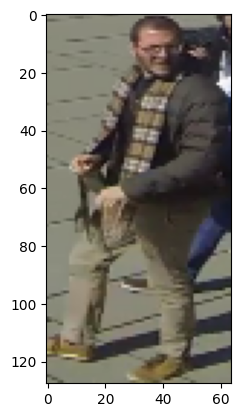

In [148]:
idx=picked_id
n=np.argmin(objects_sim[idx])

plt.imshow(objects[idx][n]/255)

In [175]:
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('output.avi', fourcc, 29.7, frames.shape[1:3][::-1])

out_frames=[]

for i in range(len(frames)):
    _frame=frames[i].copy()
    for t in tracked[i]:
        x1, y1, x2, y2, pid = t

        bbox_color=(255,0,0)
        if pid==picked_id:
            bbox_color=(0,255,0)
        elif pid in candidates_id:
            bbox_color=(255,255,0)

        cv2.rectangle(_frame, (int(x1), int(y1)), (int(x2), int(y2)), bbox_color, 2)
        
    out.write(_frame[...,::-1])
    out_frames.append(_frame)
out.release()

(1280, 720)

In [153]:
i=100

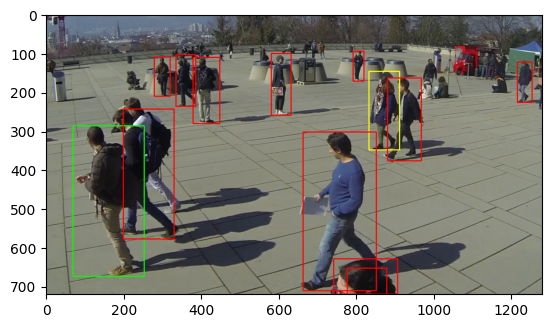

In [170]:
plt.imshow(out_frames[i])
i+=1

In [ ]:
app = Flask(__name__)

# model =load_model('path/to/load', compile=False) # <--------------------------------- 여기서 모델 로드

def build_preflight_response():
    response = make_response()
    response.headers.add("Access-Control-Allow-Origin", "*")
    response.headers.add('Access-Control-Allow-Headers', "*")
    response.headers.add('Access-Control-Allow-Methods', "*")
    return response

def build_actual_response(response):
    response.headers.add("Access-Control-Allow-Origin", "*")
    return response



def model_process(frames):
    
    return frames


detect_person=detect


@app.route('/upload', methods=['POST', 'OPTIONS'])
def process_video():
    if request.method == 'OPTIONS': 
        return build_preflight_response()
        
    elif request.method == 'POST': 
        data=json.loads(request.data)
        if 'video' not in data and 'image' not in data:
            response = app.response_class(
            response=json.dumps({'error': 'No video or image file uploaded'}),
            status=503,
            mimetype='application/json',
            )
            return response
        
        results=dict()
        
        if 'video' in data:
            video_data = data['video'].split('base64,')[1]
            # Encode the video file as Base64
            # video_data = base64.b64encode(video_file.read())

            # Decode the Base64 string back to video file
            decoded_video_data = base64.b64decode(video_data)

            try:
                frames=iio.imread(decoded_video_data, index=None)

                model_out = model_process(frames)

                results['video_result']=base64.b64encode(model_out.tobytes()).decode('UTF-8')
            except:
                response = app.response_class(
                response=json.dumps({'error': 'Failed to open video file'}),
                status=503,
                mimetype='application/json',
                )
                return response
            
        else:
            frame = base64.b64decode(data['image'].split('base64,')[1])
            
            frame = tf.io.decode_jpeg(frame)
            
            frame = tf.image.resize(frame, (128,64))
            model_out = detect_person(frame)
            
            results['image_result']=base64.b64encode(model_out.tobytes()).decode('UTF-8')
            
            
        response = app.response_class(
        response=json.dumps(results),
        status=200,
        mimetype='application/json',
        )

        return response



# SSL=ssl.SSLContext(ssl.PROTOCOL_TLS)
# SSL.load_cert_chain(certfile='cert.pem', keyfile='key.pem')
CORS(app, resources={r"*": {"origins": "*"}})
# app.run(host='0.0.0.0', port=4000, ssl_context=SSL, debug=True)
app.run(host='0.0.0.0', port=4000, debug=True)
